In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
sns.set_style('white')


In [2]:
df = pd.read_excel('../原始数据/附件1：物流网络历史货量数据.xlsx')
df

场地1   场地2         日期     货量
0        DC3   DC5 2021-01-01      3
1        DC3  DC10 2021-01-01      4
2        DC3  DC14 2021-01-01      4
3        DC5   DC3 2021-01-01     41
4        DC5   DC9 2021-01-01      3
...      ...   ...        ...    ...
177842  DC73   DC5 2022-12-31   2479
177843  DC73   DC8 2022-12-31    150
177844  DC73  DC10 2022-12-31   8116
177845  DC73  DC14 2022-12-31   6139
177846  DC73  DC62 2022-12-31  15357

[177847 rows x 4 columns]

In [3]:
# 长表转宽表
df_pivot = df.pivot_table(index=['日期'], columns=['场地1', '场地2'], values='货量', aggfunc='sum')
df_pivot.fillna(0, inplace=True)
df_pivot

场地1         DC1   DC10                                              ...  DC9   
场地2         DC8   DC12 DC13     DC14 DC17 DC19 DC20 DC21 DC22 DC23  ...  DC4   
日期                                                                  ...        
2021-01-01  0.0  306.0  0.0   2613.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  \
2021-01-02  0.0  328.0  0.0   2941.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2021-01-03  0.0  163.0  0.0   5968.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2021-01-04  0.0  193.0  0.0   4459.0  0.0  0.0  0.0  1.0  9.0  0.0  ...  0.0   
2021-01-05  0.0  565.0  0.0   7646.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...         ...    ...  ...      ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022-12-27  0.0    0.0  0.0  15492.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2022-12-28  0.0    0.0  0.0   8230.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2022-12-29  0.0    0.0  0.0  29021.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2022-12-30  0.0    0.0  0.0   9991.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0   
2022-12-31  0.0    0.0  0.0  13254.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

场地1                                                          
场地2        DC40 DC48      DC5 DC51 DC58 DC62 DC67 DC79  DC8  
日期                                                           
2021-01-01  1.0  0.0   7496.0  0.0  0.0  0.0  0.0  0.0  0.0  
2021-01-02  0.0  0.0   7557.0  0.0  0.0  0.0  0.0  0.0  0.0  
2021-01-03  0.0  0.0   6116.0  0.0  0.0  0.0  0.0  0.0  0.0  
2021-01-04  0.0  0.0  15813.0  0.0  0.0  0.0  0.0  0.0  0.0  
2021-01-05  0.0  0.0   5009.0  0.0  0.0  0.0  0.0  0.0  0.0  
...         ...  ...      ...  ...  ...  ...  ...  ...  ...  
2022-12-27  0.0  0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2022-12-28  0.0  0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2022-12-29  0.0  0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2022-12-30  0.0  0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2022-12-31  0.0  0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[730 rows x 1049 columns]

In [4]:
df['场地1'] = df['场地1'].str.replace('DC', '')
df['场地2'] = df['场地2'].str.replace('DC', '')
df['场地1'] = df['场地1'].astype('int64')
df['场地2'] = df['场地2'].astype('int64')

print(df.dtypes)
df

场地1             int64
场地2             int64
日期     datetime64[ns]
货量              int64
dtype: object


场地1  场地2         日期     货量
0         3    5 2021-01-01      3
1         3   10 2021-01-01      4
2         3   14 2021-01-01      4
3         5    3 2021-01-01     41
4         5    9 2021-01-01      3
...     ...  ...        ...    ...
177842   73    5 2022-12-31   2479
177843   73    8 2022-12-31    150
177844   73   10 2022-12-31   8116
177845   73   14 2022-12-31   6139
177846   73   62 2022-12-31  15357

[177847 rows x 4 columns]

In [5]:
# 原始的二维数组
arr = df.iloc[:, 0:2].values.tolist()

# 提取所有的节点名称
nodes = list(set([i for j in arr for i in j]))

# 对节点名称进行编号，生成一个字典
node2id = {node: i for i, node in enumerate(nodes)}

# 创建一个空的邻接矩阵
n = len(nodes)
adj_matrix = np.zeros((n, n), dtype=int)

# 遍历二维数组，将边添加到邻接矩阵中
for edge in arr:
    i, j = node2id[edge[0]], node2id[edge[1]]
    adj_matrix[i, j] = 1

# 将邻接矩阵转换为 pandas DataFrame，并添加节点名称
adj_matrixDf = pd.DataFrame(adj_matrix, columns=nodes, index=nodes)

# 打印邻接矩阵
adj_matrixDf


1   2   3   4   5   6   7   8   9   10  ...  72  73  74  75  76  77  78   
1    0   0   0   0   0   0   0   1   0   0  ...   0   0   0   0   0   0   0  \
2    0   0   1   1   1   0   0   1   1   1  ...   0   0   0   0   0   0   0   
3    0   0   0   1   1   0   0   1   1   1  ...   0   0   0   0   0   0   0   
4    0   0   1   0   1   0   0   1   1   1  ...   0   0   0   0   0   0   0   
5    0   0   1   1   0   0   0   1   1   1  ...   0   0   0   0   0   0   0   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
77   0   0   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   0   
78   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
79   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
80   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
81   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

    79  80  81  
1    0   0   0  
2    0   0   0  
3    0   0   0  
4    0   0   0  
5    0   0   0  
..  ..  ..  ..  
77   0   0   0  
78   0   0   0  
79   0   0   0  
80   0   0   0  
81   0   0   0  

[81 rows x 81 columns]

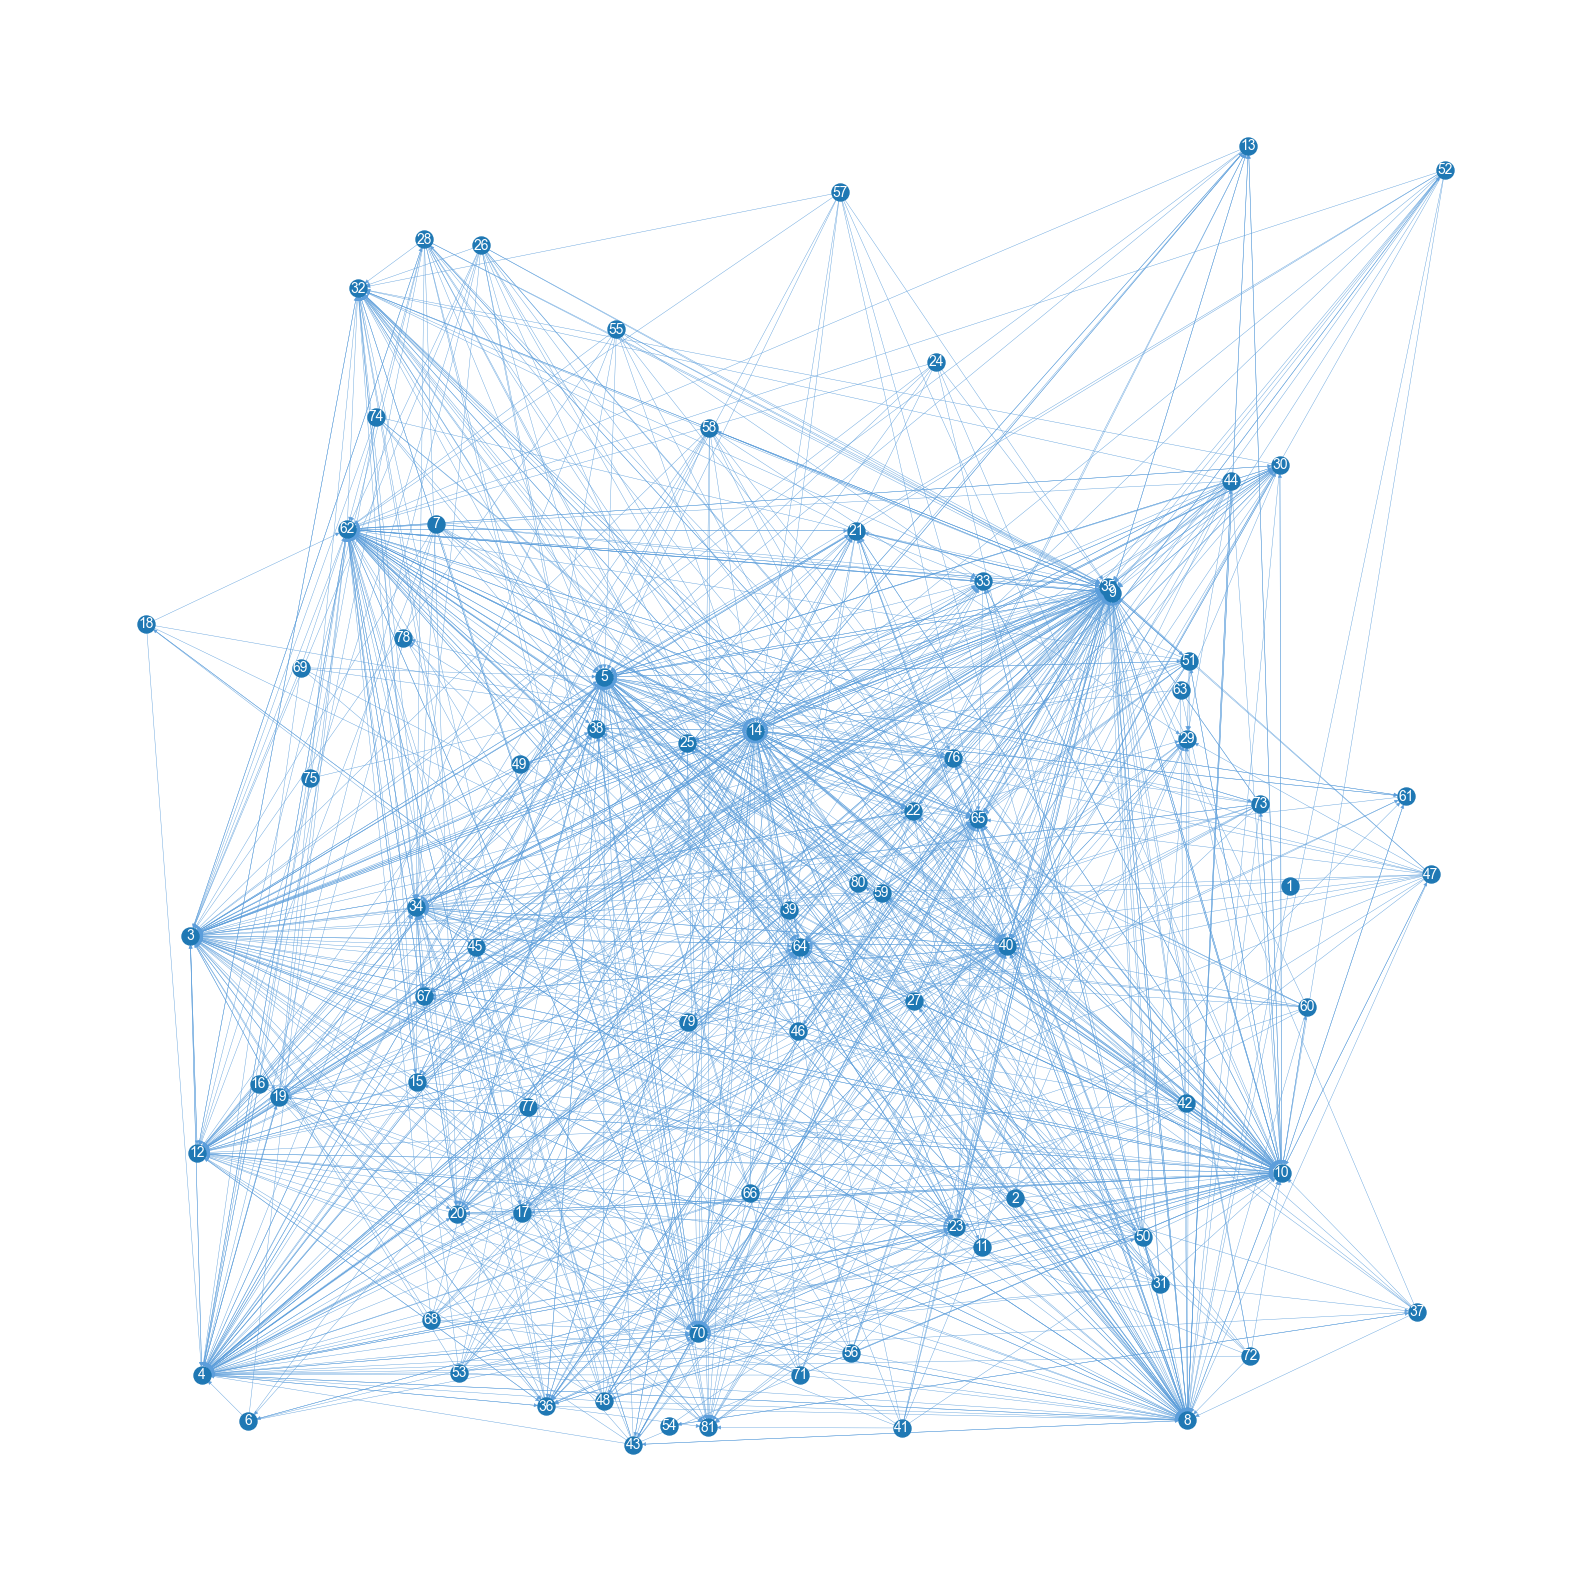

In [23]:
plt.figure(figsize=(16, 16))
G = nx.DiGraph(adj_matrixDf)

pos = nx.random_layout(G, seed=2)
# # 螺旋布局
# pos = nx.spiral_layout(G)
nx.draw_networkx(G, pos, with_labels=True, width=0.3, arrowsize=6, font_size=10, node_size=150, font_color='white',
                 edge_color='#5c9edb')

# 关闭周围的轴线并设置背景色为白色
plt.axis('off')
# plt.gca().set_axis_bgcolor('white')
plt.tight_layout()
plt.savefig('scatter map.svg')
plt.show()

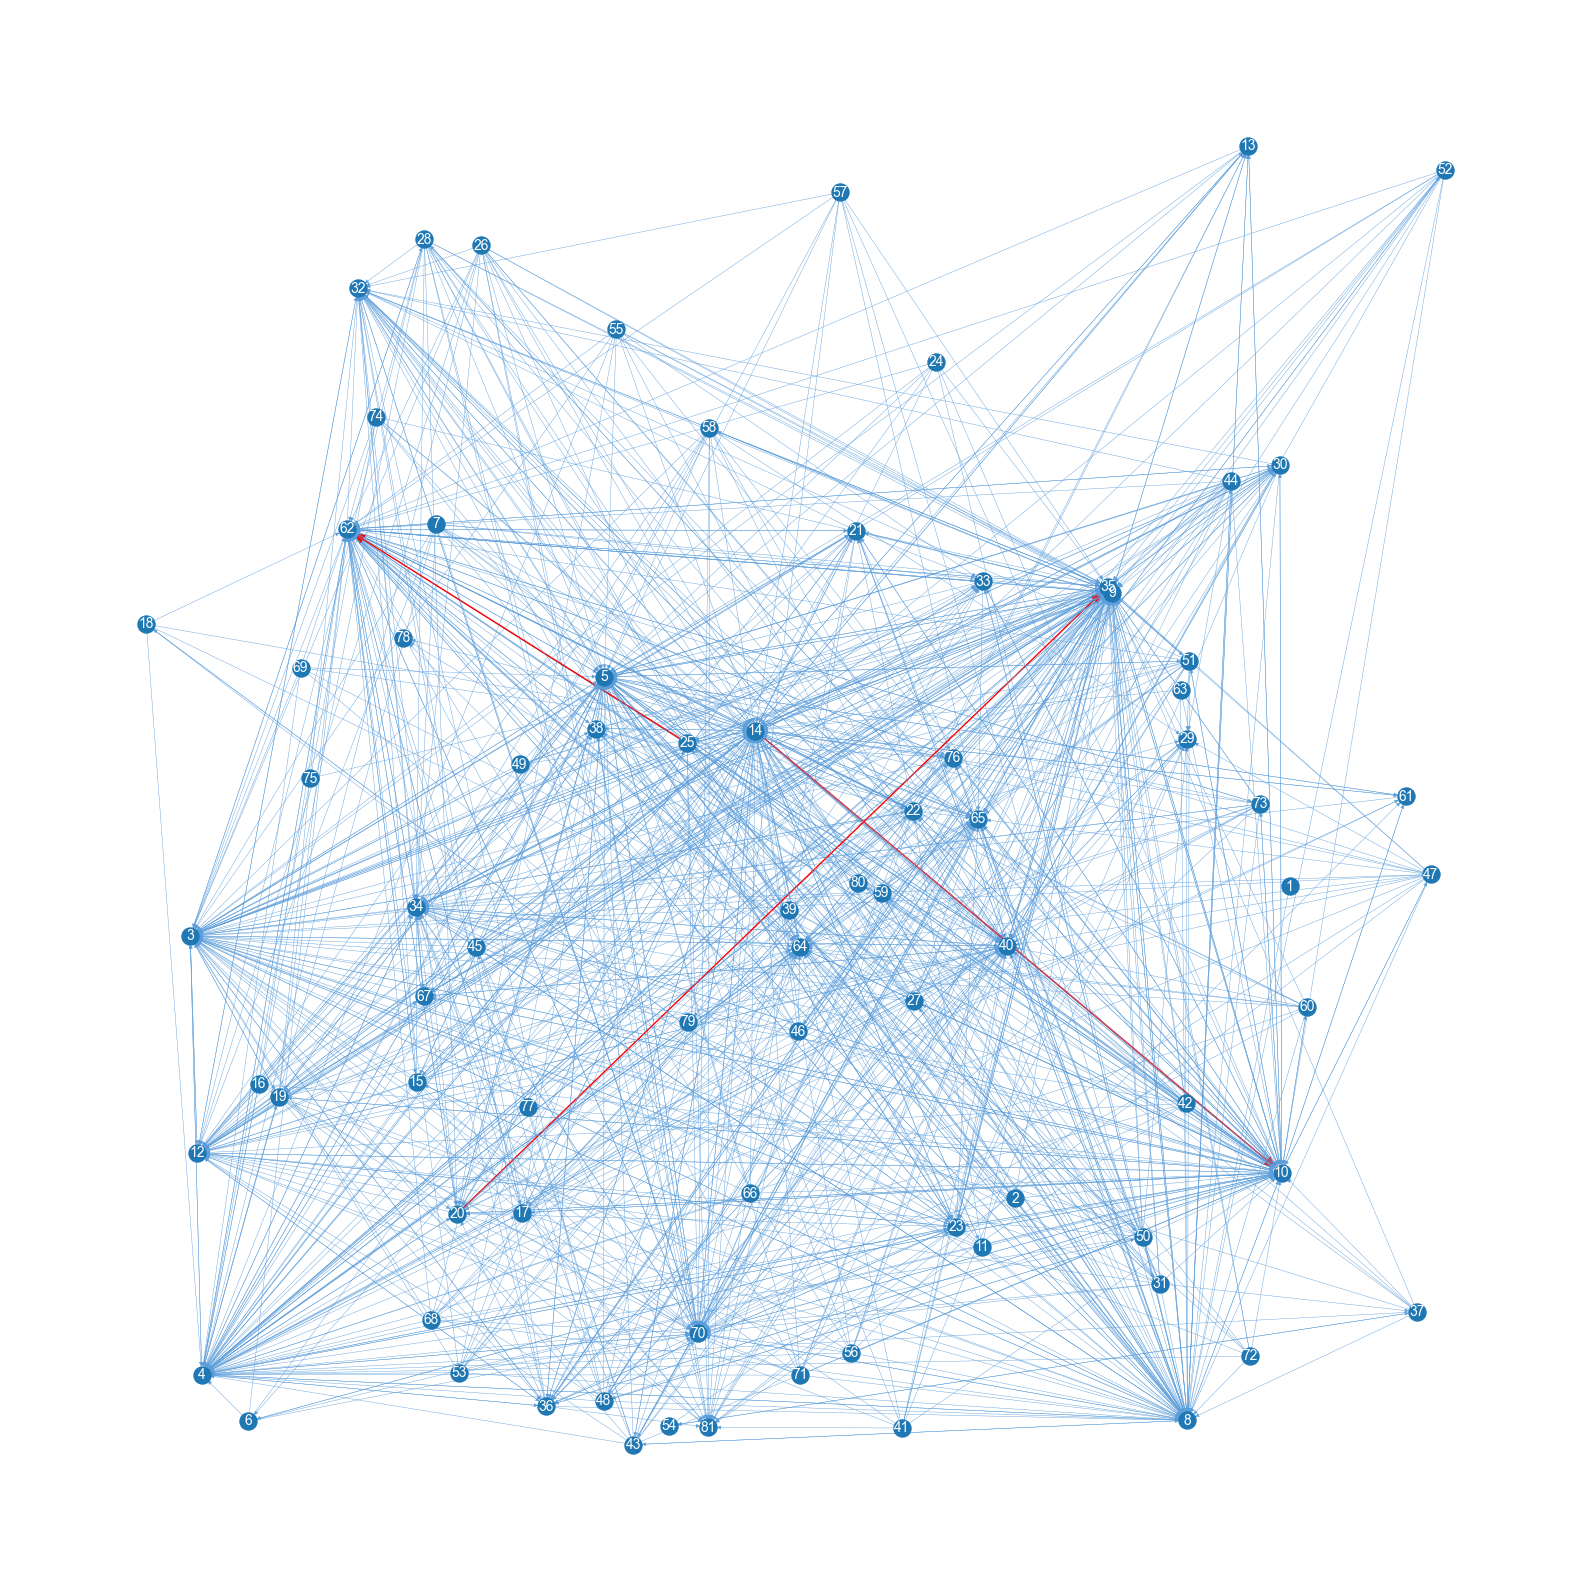

In [26]:
# 标红

plt.figure(figsize=(16, 16))
G = nx.DiGraph(adj_matrixDf)

# 设置与特定节点相连的边为红色和加粗
tagList = [(14, 10), (20, 35), (25, 62)]
edge_colors = ['red' if (u, v) in tagList else '#5c9edb' for u, v in G.edges()]
edge_widths = [1.0 if (u, v) in tagList else 0.3 for u, v in G.edges()]
arrowsize = [15 if (u, v) in tagList else 6 for u, v in G.edges()]

pos = nx.random_layout(G, seed=2)
# # 螺旋布局
# pos = nx.spiral_layout(G)
nx.draw_networkx(G, pos, with_labels=True, arrowsize=arrowsize, font_size=10, node_size=150, font_color='white',
                 edge_color=edge_colors, width=edge_widths)

# 关闭周围的轴线并设置背景色为白色
plt.axis('off')
# plt.gca().set_axis_bgcolor('white')
plt.tight_layout()
plt.savefig('scatter map - tagging.svg')
plt.show()